In [1]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

# The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard 
# deviation of the MNIST dataset. This is equivalent to scaling all pixel values between [0, 1].
transform = torchvision.transforms.Compose([
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(
                (0.1307,), (0.3081,))
            ])

train_data = torchvision.datasets.MNIST('', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST('', train=False, download=True, transform=transform)

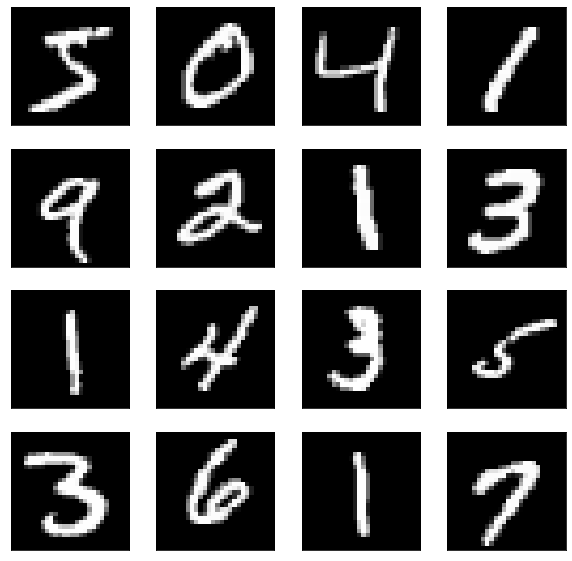

In [2]:
# Visualize the first 16 elements of the training set
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(train_data.data[i], cmap='gray')

In [3]:
# Define the model
#Set the image size for width and height
image_size = [28, 28]

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        ##SET VARIABLES##
        self.weight_mean = 0
        self.weight_variance = 0.0025
        self.weight_std = np.sqrt(self.weight_variance)
        self.bias_constant = 0.1
    
        # Layer 1: Convolutional Layer with 28 filters of size 5x5x1
        self.conv_layer = self.add_conventional_layer(1, 28, 5, 1, 2)  #grayscale image (1 channel)
        
        # Layer 2: Pool Layer of square window of size=2, stride=2
        self.pool_layer = torch.nn.MaxPool2d(2, stride=2)
        
        # Layer 3: Convolutional Layer with 16 filters of size 5x5x28
        self.conv_layer_two = self.add_conventional_layer(28, 16, 5, 1, 0)
        
        # Layer 4: Pool Layer of square window of size=2, stride=2
        self.pool_layer_two = torch.nn.MaxPool2d(2, stride=2)
        
        #Layer 5: Flatten Layer 
        self.flatten_layer = torch.nn.Flatten()
        
        #Calculate the outputs using previous layers (using pointers to make code shorter) (Done caluclations rather than hardcode)
        conv1_out = self.calculate_conv_dimensions(image_size[0], image_size[1], 5, 1, 2)
        pool1_out = self.calculate_pool_dimensions(*conv1_out, 2, 2)
        conv2_out = self.calculate_pool_dimensions(*pool1_out, 5, 1)
        pool2_out = self.calculate_pool_dimensions(*conv2_out, 2, 2)
        
        # Calculate the total input size for the linear layer
        total_input = pool2_out[0] * pool2_out[1] * 16

        #16 * 5 * 5
        # Layer 6: Dense(Linear) Layer
        self.fc1_layer = torch.nn.Linear(total_input,1024) 

        # Layer 7: Dense(Linear) Layer
        self.fc2_layer = torch.nn.Linear(1024,128)
        
        # Layer 8: Dropout Layer with 0.2 rate
        self.drop_layer = torch.nn.Dropout(p=0.2)
        
        # Layer 8: Final Dense(Linear) Layer with 10 output units
        self.fc3_layer = torch.nn.Linear(128, 10)

        # Log_softmax activation function
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
    
    # Compute the new height and width after conv
    def calculate_conv_dimensions(self, height, width, kernel, stride, padding):
        new_height = ((height - kernel + 2 * padding) // stride) + 1
        new_width = ((width - kernel + 2 * padding) // stride) + 1
        return new_height, new_width
    
    # Compute for the new height and width after pool
    def calculate_pool_dimensions(self, height, width, pool_size, stride):
        new_height = ((height - pool_size) // stride) + 1
        new_width = ((width - pool_size) // stride) + 1
        return new_height, new_width

    # Forward pass through the network
    def forward(self, x):
        
        # Layer 1: Convolutional Layer with ReLU non-linearity
        x = torch.nn.functional.relu(self.conv_layer(x))
        
        # Layer 2: Pool layer
        x = self.pool_layer(x)
            
        # Layer 3: Convolutional Layer with ReLU non-linearity
        x = torch.nn.functional.relu(self.conv_layer_two(x))
        
        # Layer 4: Pool layer
        x = self.pool_layer_two(x)
        
        #Layer 5: Flatten layer
        x = self.flatten_layer(x)
        
        # Layer 6: Desne (Linear) layer
        x = torch.nn.functional.relu(self.fc1_layer(x))
        
        # Layer 7: Desne (Linear) layer
        x = torch.nn.functional.relu(self.fc2_layer(x))
        
        # Layer 8: Apply Dropout
        x = self.drop_layer(x)

        # Layer 9: Final Dense(Linear) Layer
        x = torch.nn.functional.relu(self.fc3_layer(x))

        # Apply LogSoftmax
        x = self.log_softmax(x)
        
        return x
    
    #Add a conventional layer
    def add_conventional_layer(self, input_val, filter_val, kernel_val, stride_val, padding_val):
        
        # Passing params through the Convolutional Layer
        conv_layer = torch.nn.Conv2d(input_val, filter_val, kernel_val, stride_val, padding_val)

        # Manually initialize weights as Gaussian random variables
        torch.nn.init.normal_(conv_layer.weight, self.weight_mean, self.weight_std)  # Variance = 0.0025
        torch.nn.init.constant_(conv_layer.bias, self.bias_constant) # constant of 0.1

        return conv_layer
    
#Set model to summarise
model = CNN()
summary(model, (1, image_size[0], image_size[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 28, 28]             728
         MaxPool2d-2           [-1, 28, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]          11,216
         MaxPool2d-4             [-1, 16, 5, 5]               0
           Flatten-5                  [-1, 400]               0
            Linear-6                 [-1, 1024]         410,624
            Linear-7                  [-1, 128]         131,200
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
       LogSoftmax-10                   [-1, 10]               0
Total params: 555,058
Trainable params: 555,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 2.12
Estimated T

In [4]:
# PyTorch requires that we specify a device. This is the CPU or GPU that PyTorch will use to run the model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define variables
val_ratio = 0.1
learning_rate = 1e-2
momentum = 0.9

## Cross-entropy loss function ##
criterion = torch.nn.CrossEntropyLoss()

## Splitting the dataset into training and validation ##

#Get the train data length for splitting (10% of data for validation)
num_train = int((1 - val_ratio) * len(train_data))
num_val = len(train_data) - num_train

#Split data accordingly
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [num_train, num_val])

## Optimize model ##

# Setting the model
model = CNN().to(device)

# SGD Optimizer
optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum)

## Training Algorithm ##
def training_algorithm(train_dataset, train_loader, val_dataset, val_loader, batch_size, device):

    #Train model
    model.train()

    #Define variables
    train_loss, train_corrects = 0.0, 0
    
    #Loop every batch
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass, Compute the gradient of the loss with respect to the model's parameters.
        loss.backward()   
        
        # Update model's parameters
        optimizer.step()
        
        # Sum up the loss for reporting/tracking purposes. Has no effect on the training
        train_loss += loss.item() 

        # Calculate accuracy
        null, preds = torch.max(outputs.data, 1) #ignoring first value 'null' as not needed
        train_corrects += torch.sum(preds == labels)
    
    #Calculate the average training loss and accuracy
    train_accuracy = train_corrects / len(train_loader.dataset)
    train_loss = train_loss / len(train_loader)
    
    #Set model to evaluation mode
    model.eval()

    #define variables
    val_corrects, val_loss = 0, 0
    
    # No gradients are computed within this block, optimizing computation for evaluation purposes
    with torch.no_grad():
        
        # Validation loop: Evaluate the model's performance on the validation dataset
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            
            ## We do not perform a backward pass or update the model parameters during validation like before ##
            ## because the purpose here is to evaluate the model's performance on unseen data.##
            
            # Sum up the loss for reporting/tracking purposes. Has no effect on the training
            val_loss += loss.item()

            # Calculate accuracy
            null, preds = torch.max(outputs.data, 1) #ignoring first value 'null' as not needed
            val_corrects += torch.sum(preds == labels)

    #Calculate the average validation loss and accuracy
    val_loss = val_loss / len(val_loader)
    val_accuracy = val_corrects / len(val_loader.dataset)
    
    #Print the current epoch, validation accuracy and training accuracy
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Accuracy: {val_accuracy:.4f}, Training Accuracy: {train_accuracy:.4f},')
    
    return model, val_accuracy, train_accuracy, val_loss, train_loss

In [5]:
# Define variables
num_epochs = 50
batch_size = 32
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

## DataLoader for training and validation ##
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True) #Shuffling training data for randomness and better generalization.
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False) #Not shuffling validation data for consistent evaluation.

##Training Loop##
for epoch in range(num_epochs):
    
    #Run the training algorithm
    model, val_accuracy, train_accuracy, val_loss, train_loss = training_algorithm(train_dataset, train_loader, val_dataset, val_loader, batch_size, device)
    
    # Append these values to their respective lists to use for later observation
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)
    val_loss_values.append(val_loss)
    val_accuracy_values.append(val_accuracy)

#Evaluate the model on the test dataset##
test_corrects = 0
model.eval()

##DataLoader for test##
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

# No gradients are computed within this block, optimizing computation for evaluation purposes
with torch.no_grad():
    
    # Testing loop: Evaluate the model's performance on the test dataset
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate accuracy
        null, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels)

Epoch [1/50], Validation Accuracy: 0.9773, Training Accuracy: 0.9335,
Epoch [2/50], Validation Accuracy: 0.9848, Training Accuracy: 0.9828,
Epoch [3/50], Validation Accuracy: 0.9860, Training Accuracy: 0.9883,
Epoch [4/50], Validation Accuracy: 0.9875, Training Accuracy: 0.9911,
Epoch [5/50], Validation Accuracy: 0.9900, Training Accuracy: 0.9934,
Epoch [6/50], Validation Accuracy: 0.9912, Training Accuracy: 0.9944,
Epoch [7/50], Validation Accuracy: 0.9892, Training Accuracy: 0.9960,
Epoch [8/50], Validation Accuracy: 0.9908, Training Accuracy: 0.9958,
Epoch [9/50], Validation Accuracy: 0.9905, Training Accuracy: 0.9972,
Epoch [10/50], Validation Accuracy: 0.9880, Training Accuracy: 0.9973,
Epoch [11/50], Validation Accuracy: 0.9922, Training Accuracy: 0.9970,
Epoch [12/50], Validation Accuracy: 0.9880, Training Accuracy: 0.9976,
Epoch [13/50], Validation Accuracy: 0.9907, Training Accuracy: 0.9980,
Epoch [14/50], Validation Accuracy: 0.9915, Training Accuracy: 0.9984,
Epoch [15/50], 

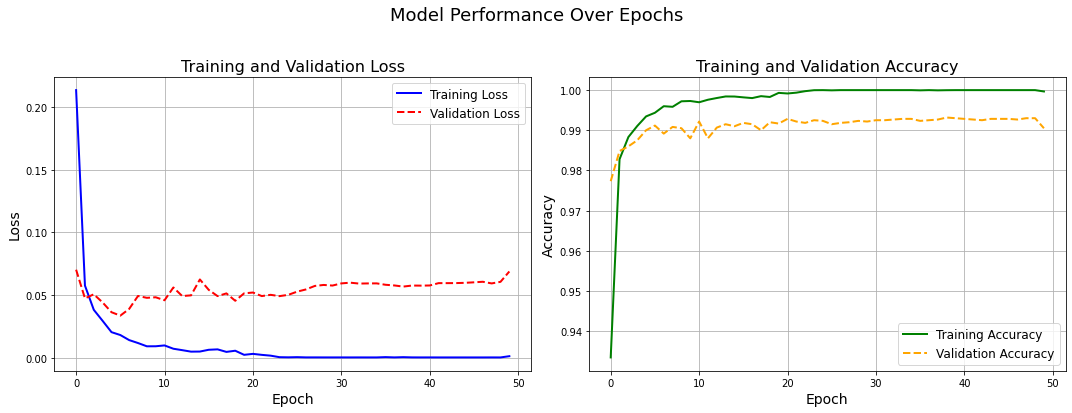

Test Accuracy: 0.9911


In [6]:
plt.figure(figsize=(15, 6))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Training Loss', color='blue', linewidth=2, linestyle='-')
plt.plot(val_loss_values, label='Validation Loss', color='red', linewidth=2, linestyle='--')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_values, label='Training Accuracy', color='green', linewidth=2, linestyle='-')
plt.plot(val_accuracy_values, label='Validation Accuracy', color='orange', linewidth=2, linestyle='--')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# General Title for the Figure
plt.suptitle('Model Performance Over Epochs', fontsize=18)

# Adjust Layout and Show Plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print out test accuracy
test_accuracy = test_corrects / len(test_loader.dataset)
print(f'Test Accuracy: {test_accuracy:.4f}')